## Get the best runs

In [18]:
import neptune
from misc import save_json
import pandas as pd
import numpy as np
import os
from utils_neptune import start_neptune_run
from paretoset import paretoset
import matplotlib.pyplot as plt
import seaborn as sns


NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [3]:
def pareto_reduction(df, sense_list=None, current_set=None, desired_num=None, objective_cols=None):
    if desired_num is None:
        desired_num = np.floor(0.2*df.shape[0])
    if objective_cols is None:
        objective_cols = df.columns

    if df.shape[0] < desired_num*1.5:
        return df

    mask = paretoset(df[objective_cols], sense=sense_list)
    current_set = pd.concat([current_set, df[mask]])
    if current_set.shape[0] < desired_num:
        return pareto_reduction(df[~mask], sense_list, current_set, desired_num, objective_cols)
    else:
        return current_set

In [21]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    
    return df_out

In [31]:
encoder_kind = 'AE'
project = neptune.init_project(
    project='revivemed/RCC',
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

runs_table_df = project.fetch_runs_table(tag=['v3.1'],state='inactive').to_pandas()

#drop the failed runs
runs_table_df = runs_table_df[~runs_table_df['sys/failed']].copy()

#filter by encoder_kind
runs_table_df = runs_table_df[runs_table_df['pretrain/kwargs/encoder_kind'] == encoder_kind].copy()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/


Fetching table...: 0 [00:00, ?/s]

In [32]:
cols = ['sys/id']
obj_cols = [col for col in runs_table_df.columns if 'objectives/OBJ' in col]
obj_cols = [col for col in obj_cols if '(v2)' in col]
cols.extend(obj_cols)
df = runs_table_df[cols].copy()
df.set_index('sys/id', inplace=True)
df.columns = [col.split('/')[-1] for col in df.columns]
obj_cols = [col.split('/')[-1] for col in obj_cols]

In [33]:
obj_cols

['OBJ Adv StudyID (v2)', 'OBJ Clasifiers (v2)']

In [34]:
# remove outliers 
df = remove_outliers(df, obj_cols[1])

<Axes: xlabel='OBJ Adv StudyID (v2)', ylabel='OBJ Clasifiers (v2)'>

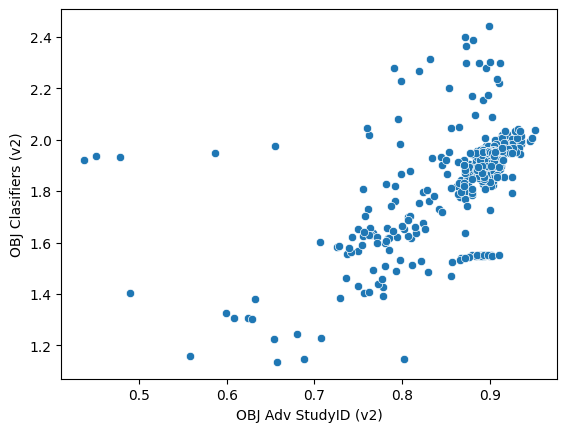

In [35]:

sns.scatterplot(data=df, x=obj_cols[0], y=obj_cols[1])

In [36]:
res = pareto_reduction(df, sense_list=['min','max'], desired_num=5, objective_cols=obj_cols)

In [37]:
res

,OBJ Adv StudyID (v2),OBJ Clasifiers (v2)
sys/id,,
RCC-1601,0.790090,2.278044
RCC-1593,0.898678,2.442455
RCC-1588,0.831093,2.315494
RCC-1564,0.871717,2.399004
RCC-1563,0.654813,1.976159
RCC-1556,0.759481,2.043593
RCC-1416,0.437361,1.920582
RCC-1275,0.451504,1.934779
RCC-1218,0.587067,1.946833


In [ ]:
# add the tag to the top runs
chosen_runs = res.index.tolist()

for run_id in chosen_runs:
    run, _ = start_neptune_run(with_id=run_id)
    run['sys/tags'].add('april03_pareto')
    run.stop()

In [6]:
df

,OBJ Adv StudyID (v2),OBJ Clasifiers (v2)
sys/id,,
RCC-1601,0.790090,2.278044
RCC-1600,0.853541,2.199447
RCC-1598,0.894948,2.562835
RCC-1596,0.901753,2.649675
RCC-1595,0.879192,2.169417
...,...,...
RCC-932,NaN,NaN
RCC-930,NaN,NaN
RCC-927,NaN,NaN
